## Compute Sagnac Frequency - Spectra - Compare Before/After

## Imports

In [1]:
import os
import matplotlib.pyplot as plt

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime
from numpy import log10


In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

## Configurations

In [20]:
config = {}

# ## ring
# config['ring'] = "U"

# ## time before change
# config['tbeg1'] = UTCDateTime("2024-05-01 18:00")
# config['tend1'] = UTCDateTime("2024-05-01 18:10")

# ## time after change
# config['tbeg2'] = UTCDateTime("2024-05-02 18:00")
# config['tend2'] = UTCDateTime("2024-05-02 18:10")

## ring
config['ring'] = "V"

## time before change
config['tbeg1'] = UTCDateTime("2024-05-19 16:00")
config['tend1'] = UTCDateTime("2024-05-19 16:10")

## time after change
config['tbeg2'] = UTCDateTime("2024-05-22 16:00")
config['tend2'] = UTCDateTime("2024-05-22 16:10")




config['seeds'] = [f"BW.DROMY..FJ{config['ring']}", f"BW.DROMY..FJ{config['ring']}"]

config['path_to_sds'] = archive_path+"romy_archive/"

config['zooms'] = {"U":(301, 303), "V":(445, 450), "Z":(551, 555), "W":(445, 450)}

config['f_lower_zoomin'], config['f_upper_zoomin'] = config['zooms'][config['ring']]


config['datapath'] = data_path+"sagnac_frequency/prismspectra/"

config['path_to_figs'] = data_path+"sagnac_frequency/figures/"


In [21]:
def __compute_psd(st0, twin_sec=60):

    from scipy.signal import welch, hann

    _st = st0.copy()

    _st.sort(keys=['channel'], reverse=True)

    nblock = int(st[0].stats.sampling_rate * twin_sec)
    overlap = int(0.5*nblock)
    win = hann(nblock, True)

    Pxxs, ffs, chs = [], [], []

    _st = _st.detrend("linear")
    _st = _st.detrend("demean")

    for i, tr in enumerate(_st):

        ff, Pxx = welch(tr.data,
                        fs=tr.stats.sampling_rate,
                        window=win,
                        noverlap=overlap,
                        nfft=nblock,
                        scaling="density",
                        return_onesided=True,
                       )

        ffs.append(ff)
        chs.append(tr.stats.channel)
        Pxxs.append(Pxx)

    out = {}
    out['Pxxs'] = Pxxs
    out['ffs'] = ffs
    out['chs'] = chs

    return out

In [51]:
from functions.compute_psd_array import __compute_psd_array

In [22]:
def __load_romy_raw_data(seeds, tbeg, tend, path_to_sds):

    from andbro__read_sds import __read_sds
    from obspy import Stream, UTCDateTime

    st0 = Stream()

    for seed in seeds:

        print(f" -> loading {seed}...")

        try:
            st00 = __read_sds(path_to_sds, seed, tbeg,tend, data_format='MSEED')
        except:
            print(f" -> failed for {seed}")

        st0 += st00

    st0 = st0.sort()

    for tr in st0:
        tr.data = tr.data*0.59604645e-6 # V / count  [0.59604645ug  from obsidian]

    return st0

## Load Raw data

 -> loading BW.DROMY..FJV...
 -> loading BW.DROMY..FJV...


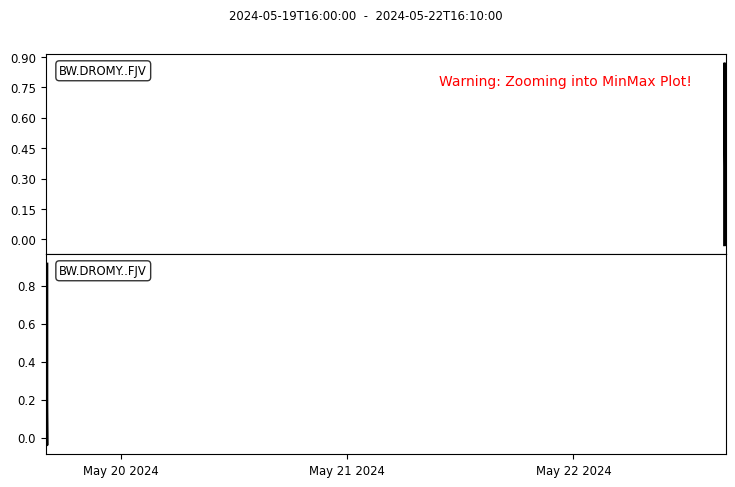

In [23]:
st1 = __load_romy_raw_data([config['seeds'][0]], config['tbeg1'], config['tend1'], config['path_to_sds'])
st2 = __load_romy_raw_data([config['seeds'][1]], config['tbeg2'], config['tend2'], config['path_to_sds'])

st = st1.copy()
st += st2.copy()

st.plot(equal_scale=False);

In [24]:
def __makeplot_stream_PSD(st, twin_sec=60, f_lower_zoom=540, f_upper_zoom=560):

    from scipy import fftpack
    from numpy import abs
    from scipy.signal import welch, hann
    import matplotlib.pyplot as plt


    nblock = int(st[0].stats.sampling_rate * twin_sec)
    overlap = int(0.5*nblock)

    print(f" -> nseg = {nblock} | overlap = {overlap}")

    win = hann(nblock, True)


    fig, axes = plt.subplots(len(st),2,figsize=(15,10), sharex='col')

    plt.subplots_adjust(hspace=0.1)

    ## _______________________________________________

    st.sort(keys=['channel'], reverse=True)

    Pxxs, ffs, chs = [], [], []

    for i, tr in enumerate(st):

        tr.data /= max(abs(tr.data))

        ff, Pxx = welch(tr.data,
                        fs=tr.stats.sampling_rate,
                        window=win,
                        noverlap=overlap,
                        nfft=nblock,
                        scaling="density",
                        return_onesided=True)

        ffs.append(ff)
        chs.append(tr.stats.channel)
        Pxxs.append(Pxx)

        ## _________________________________________________________________
        axes[i,0].plot(
                    tr.times(),
                    tr.data,
                    color='black',
                    label='{} {}'.format(tr.stats.station, tr.stats.channel),
                    lw=1.0,
                    )


        ## _________________________________________________________________
        axes[i,1].semilogy(
                    ff,
                    Pxx,
                    color='black',
                    lw=1.0,
                    )

        axes[i,1].set_ylim(min(Pxx[10:]), max(Pxx[10:]))

        axes[i,0].set_ylabel(r'U (volt)')

        axes[i,1].set_ylabel(r'PSD (volt$^2$/Hz)')

        axes[i,0].legend(loc='upper left', framealpha=.8)

#         axes[i,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#         axes[i,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

        axes[i,1].set_xlim(f_lower_zoom, f_upper_zoom)

    plt.show();
    return fig, (Pxxs, ffs, chs)

 -> nseg = 300000 | overlap = 150000


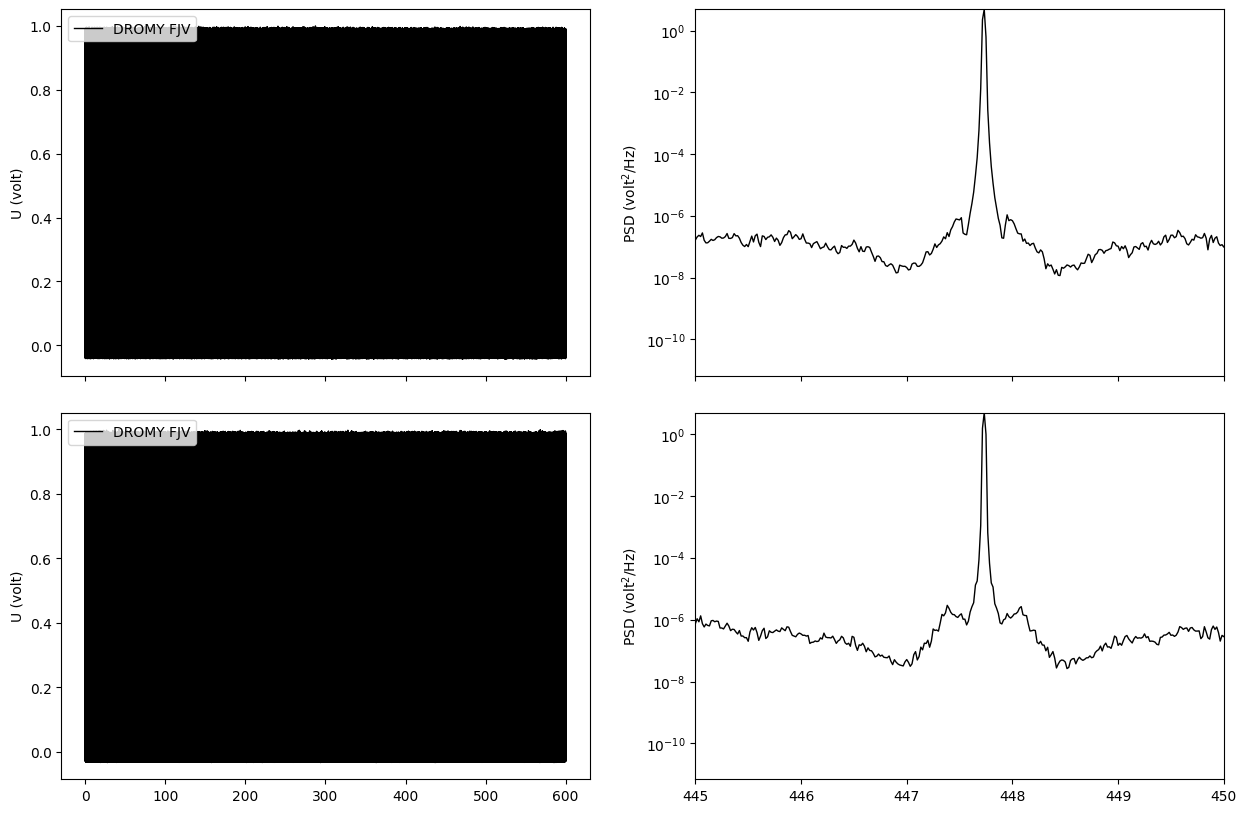

In [25]:
fig, out = __makeplot_stream_PSD(st, twin_sec=60, f_lower_zoom=config['f_lower_zoomin'], f_upper_zoom=config['f_upper_zoomin'])

 -> nseg = 600000 | overlap = 300000


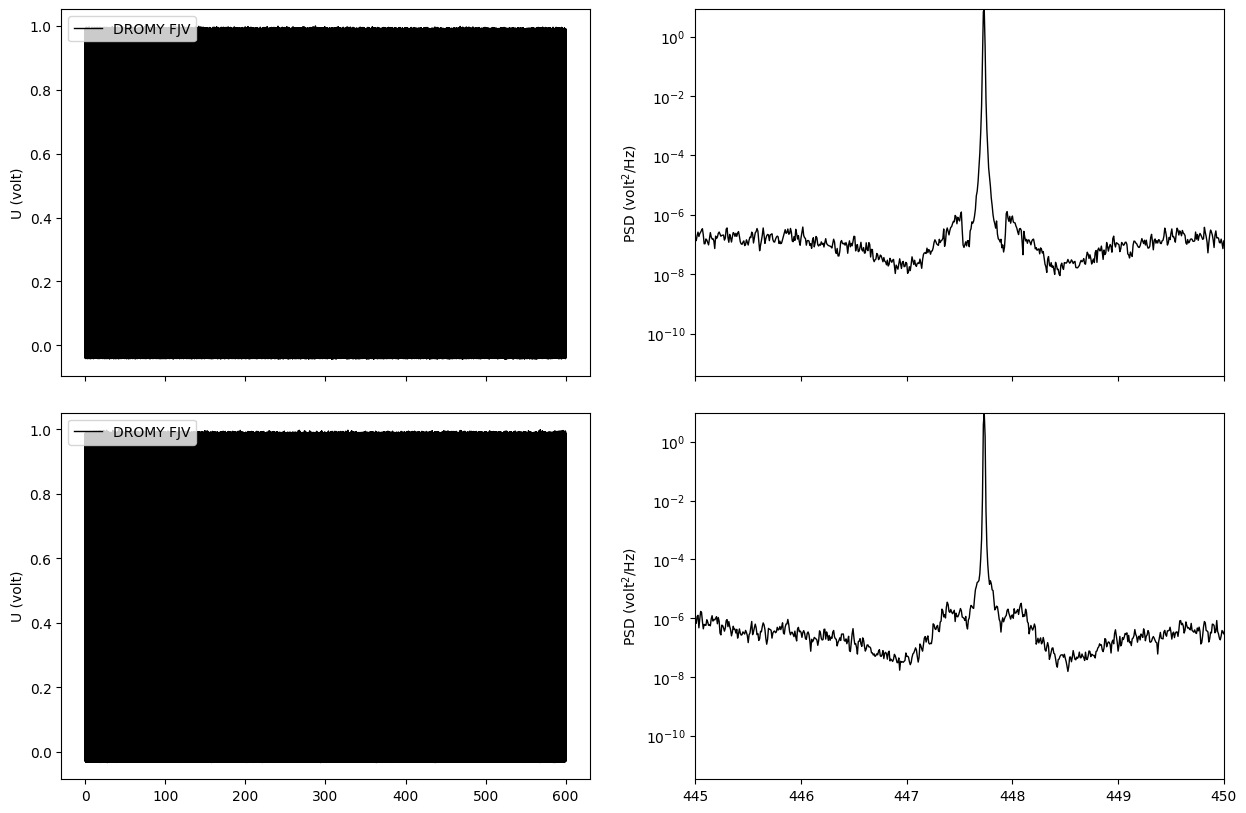

In [26]:
fig, out = __makeplot_stream_PSD(st, twin_sec=120, f_lower_zoom=config['f_lower_zoomin'], f_upper_zoom=config['f_upper_zoomin'])

fig.savefig(config['path_to_figs']+f"SF_spectra_{config['ring']}_{st[0].stats.channel}_{st[1].stats.channel}_trace&PSD.png", format="png", dpi=150, bbox_inches='tight')


## Plot Comparison

In [55]:
def __makeplot_psd_overview_with_zoomin(stx, twin_sec=60, plot_dB=True, f_lower_zoom=540, f_upper_zoom=560):

    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec
    from functions.to_dB import __to_dB
    from functions.compute_psd_array import __compute_psd_array

    font = 14

    stx = stx.detrend("demean")
    # stx = stx.normalize()

    out = __compute_psd_array(stx, twin_sec=twin_sec)
    Pxxs, ffs, chs = out['Pxxs'], out['ffs'], out['chs']


    chs[0] = chs[0]+" before"
    chs[1] = chs[1]+" after"

    fig = plt.figure(figsize=(15, 8))

    plt.subplots_adjust(wspace=0.05)

    gs = GridSpec(1, 2, width_ratios=[2, 1])

    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])

    if plot_dB:
        max_db = []
        for jj in range(len(Pxxs)):
            max_db.append(max(__to_dB(Pxxs[jj])))
    max_max_db = round(max(max_db), 0)


    for jj in range(len(Pxxs)):
        if plot_dB:
            ax1.semilogx(ffs[jj], __to_dB(Pxxs[jj])-max_max_db, alpha=0.5, label=chs[jj])
            ax2.plot(ffs[jj], __to_dB(Pxxs[jj])-max_max_db, alpha=0.5, label=chs[jj])
            ax1.set_ylim(-100, max_max_db)
            ax2.set_ylim(-100, max_max_db)
        else:
            ax1.loglog(ffs[1], Pxxs[0], alpha=0.5, label=chs[1])
            ax2.loglog(ffs[1], Pxxs[1], alpha=0.5, label=chs[1])


    ax1.grid(alpha=0.2, which="both")
    ax1.set_xlabel("Frequency (Hz)", fontsize=font)
    ax1.set_ylabel(f"PSD (dB rel. to ({max_max_db} $V^2$/Hz))", fontsize=font)
    ax1.legend(loc="upper center", fontsize=font-1, ncol=3)
    ax1.tick_params(labelsize=font-2)



    ax2.set_xlabel("Frequency (Hz)", fontsize=font)
    ax2.grid(alpha=0.2, which="both")
    ax2.tick_params(labelsize=font-2)
    ax2.set_yticklabels([])

    # ax2.set_xlim(553-100, 553+100)
    ax2.set_xlim(f_lower_zoom, f_upper_zoom)

    ax1.text(.01, .99, '(a)', ha='left', va='top', transform=ax1.transAxes, fontsize=font+2)
    ax2.text(.01, .99, '(b)', ha='left', va='top', transform=ax2.transAxes, fontsize=font+2)

    time_str1 = f"{stx[0].stats.starttime.date} {str(stx[0].stats.starttime.time).split('.')[0]} - {str(stx[0].stats.endtime.time).split('.')[0]} UTC"
    time_str2 = f"{stx[1].stats.starttime.date} {str(stx[1].stats.starttime.time).split('.')[0]} - {str(stx[1].stats.endtime.time).split('.')[0]} UTC"

    ax1.set_title(f"{time_str1} vs. {time_str2}")

    plt.show();
    return fig

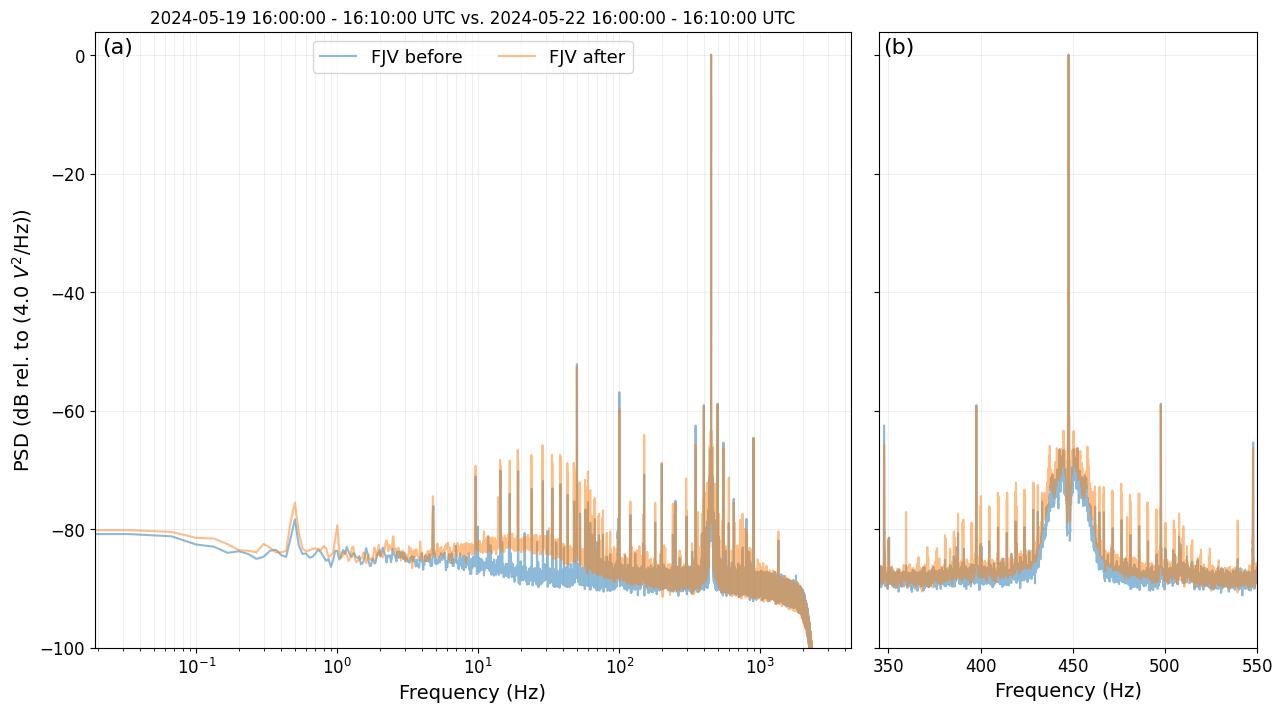

In [56]:

fig = __makeplot_psd_overview_with_zoomin(st, twin_sec=30, plot_dB=True,
                                          f_lower_zoom=config['f_lower_zoomin']-100,
                                          f_upper_zoom=config['f_upper_zoomin']+100,
                                         )

fname = f"SF_spectra_{config['ring']}_{st[0].stats.channel}_{st[1].stats.channel}_zoomin.png"
fig.savefig(config['path_to_figs']+fname, format="png", dpi=150, bbox_inches='tight')


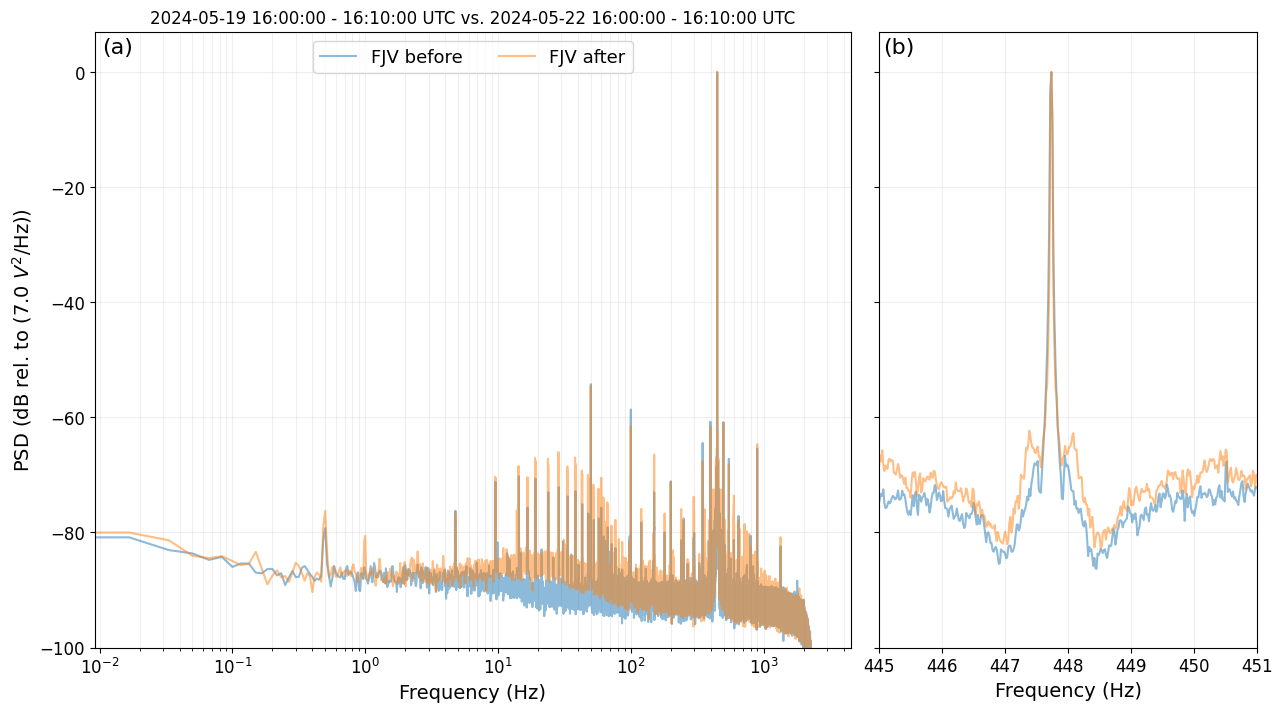

In [58]:

fig = __makeplot_psd_overview_with_zoomin(st, twin_sec=60, plot_dB=True,
                                          f_lower_zoom=config['f_lower_zoomin']+0,
                                          f_upper_zoom=config['f_upper_zoomin']+1,
                                         )

fname = f"SF_spectra_{config['ring']}_{st[0].stats.channel}_{st[1].stats.channel}_zoomin2.png"
fig.savefig(config['path_to_figs']+fname, format="png", dpi=150, bbox_inches='tight')
